In [25]:
import csv
import pandas as pd
import numpy as np
import seaborn as sns
import re
from nltk.corpus import stopwords
import nltk
import string
import matplotlib.pyplot as plt
import random
%matplotlib inline
import os

from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn import decomposition, ensemble
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import cross_val_score

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
#from nltk.corpus import stopwords
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.multiclass import OneVsRestClassifier

from sklearn.metrics import classification_report
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import confusion_matrix

import joblib

from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis


### Define which phrase to model for

In [26]:
# total 7 deletion reason based models
group = 1
deletionR = 'preventative_screening'
#deletionR = 'negation'
#deletionR = 'not_doctors_note'
#deletionR = 'not_relevant'
#deletionR = 'family_history'
#deletionR = 'phoneORaddressORother_number'
##deletionR = 'PMH' # this one I don't see it from deletion reason list, so don't know how to build a model from it

In [27]:
# total 12 phrase-based models
#group=2
#phrase = 'stroke'
#phrase = 'diabetes'
#phrase = 'cholesterol'
#phrase = 'cad'
#phrase = 'hypertension'
#phrase = 'aneurysm'
#phrase = 'asthma'
#phrase = 'cancer'
#phrase = 'ckd'
#phrase = 'dementia'
#phrase = 'depression'
#phrase = 'emphysema'

In [28]:
# total 10 code based models
#group = 3
#codereason = 'Code_Model1'
#codereason = 'Code_Model2'
#codereason = 'Code_Model3'
#codereason = 'Code_Cancer'
#codereason = 'Code_Cholesterol'
#codereason = 'Code_COPD'
#codereason = 'Code_Depression'
#codereason = 'Code_Diabetes'
#codereason = 'Code_Heart'
#codereason = 'Code_Kidney'


### Part 1  Loading the  data 

In [29]:
# the data processing and saving the 2000 charts are done in IBCdata_prepare4modeling_April022019.ipynb
trainDF=pd.read_csv('ibc_trainingdata_040219.csv')  # pd.read_csv('/home/jovyan/work/TinaZ/ibc_trainingdata_040219.csv')
testDF=pd.read_csv('ibc_testingdata_040219.csv')   #   pd.read_csv('/home/jovyan/work/TinaZ/ibc_testingdata_040219.csv')


/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### Part 2. Data  processing

In [30]:
code_list={}
code_list["Code_Model1"]=['I10','E119']
code_list["Code_Model2"]=['I2510','E785','K219','F329','I639']
code_list["Code_Model3"]=['I739','N183','Z992','B20','I213','R569','I43','J410','I714','R579','E550','I209','J45998','I480','B182','K210','K739']
code_list["Code_Heart"]=['I509','I482','I4891','I82401']
code_list["Code_Depression"]=['F411','F410','F40240','F458','F409','F4000','F4001','F445','F444','F40243','F446','F4010','F442','F408','F449','F451']
code_list["Code_Kidney"]=['N189','N181','N182','E1122','I130','E0822','E1022']
code_list["Code_Diabetes"]=['Z794','E109','E119','E139','E089','E099']
code_list["Code_Cancer"]=['C801','C50919','C189']
code_list["Code_COPD"]=['J449','J45909']
code_list["Code_Cholesterol"]=['E780','E785','E782','E789','E7800','E784','E781','E7801','E7881','E882','E783','E786','E7889','E756','E755','E7130']

In [31]:
#code_list[codereason]

In [32]:
#import re


trainDF = trainDF[pd.notnull(trainDF['cleaned_data'])]
print(len(trainDF))
trainDF = trainDF[pd.notnull(trainDF['text'])]
print(len(trainDF))

testDF = testDF[pd.notnull(testDF['cleaned_data'])]
print(len(trainDF))
testDF = testDF[pd.notnull(testDF['text'])]
print(len(testDF))

if group==1:
# if it's a deletion-based model, use the following to select data

    agreeadddata=trainDF[trainDF['flag']==0]
## or select trainDF['label']=='agreed' or 'added'
    deleteddata=trainDF[trainDF['deleted_reason']==deletionR]
    trainDF=pd.concat([agreeadddata,deleteddata])
    
    # do the same for testing data too
#    agreeadddata=testDF[testDF['flag']==0]
## or select trainDF['label']=='agreed' or 'added'
#    deleteddata=testDF[testDF['deleted_reason']==deletionR]
#    testDF=pd.concat([agreeadddata,deleteddata])
    
    
elif group==2:
# if it's phrase-based model, use the following way to select data
    trainDF = trainDF[trainDF['text'].str.contains(phrase,flags=re.IGNORECASE)]  # here use phrase variable to select data
    testDF = testDF[testDF['text'].str.contains(phrase,flags=re.IGNORECASE)]
    
elif group==3:
# if it's code based model, use the following way to select model
    trainDF = trainDF[trainDF['code_id'].isin(code_list[codereason])]
    testDF = testDF[testDF['code_id'].isin(code_list[codereason])]
else:
    print('please define a valid group...')

#trainDF = trainDF[trainDF['text75'].str.contains(r'^[0-9]')]
print(len(trainDF))
trainDF.head()

349267
349267
349267
18127
178817


,Unnamed: 0,chart_id,code_id,text,deleted_reason,deleted,label,flag,cleaned_data
0,0,002803945_161667176A_2016_001,E6601,e66.01,NaN,NaN,agreed,0,assessment morbid obesity due excess calories ...
1,1,002803945_161667176A_2016_001,E6601,e66.01,NaN,NaN,agreed,0,ise assessment morbid obesity due excess calor...
2,2,002803945_161667176A_2016_001,E789,e78.9,NaN,NaN,agreed,0,izures f445 assessment elevated serum choleste...
3,3,002803945_161667176A_2016_001,F329,f32.9,NaN,NaN,agreed,0,etter meds flared head injury assessmentmajor ...
4,4,002803945_161667176A_2016_001,F329,Major depression,NaN,NaN,agreed,0,07281977 09192016 0600 pm 336 unspecified abno...


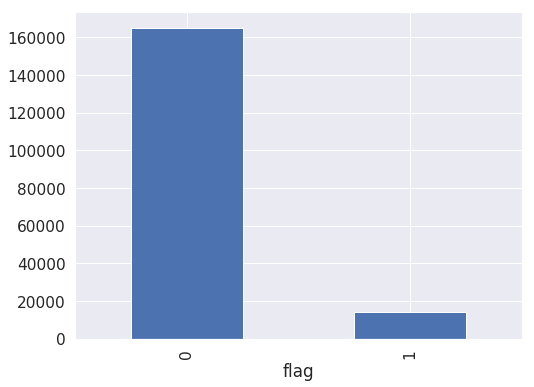

flag
0    164980
1     13837
dtype: int64

In [33]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
trainDF.groupby('flag').chart_id.count().plot.bar(ylim=0)
plt.show()
trainDF.groupby(['flag']).size()                 # 0 is agreed or added, 1 is deleted 

In [34]:
# select only two columns
col = ['cleaned_data','flag']
trainDF = trainDF[col]
trainDF = trainDF[pd.notnull(trainDF['cleaned_data'])]
trainDF.columns=['text75','flag']
trainDF.head()
testDF=testDF[col]
testDF = testDF[pd.notnull(testDF['cleaned_data'])]
testDF.columns=['text75','flag']
testDF.head()

,text75,flag
0,disorder z720 obstructive chronic bronchitis a...,0
1,initis j310 cough r05 esophageal reflux k219 h...,0
2,initis j310 cough r05 esophageal reflux k219 h...,0
3,yperlipidemia e785 mitral regurgitation 1340 m...,0
4,yperlipidemia e785 mitral fegurgithtion 1340 m...,0


### Part 3. Cross Validation Evaluation   It's not required to run

In [35]:
X_train, X_test, y_train, y_test = train_test_split(trainDF['text75'], trainDF['flag'], random_state=42, test_size=0.25, shuffle=True)
count_vect = TfidfVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
clf = MultinomialNB().fit(X_train_tfidf, y_train)

In [36]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')
features = tfidf.fit_transform(trainDF.text75)  #.toarray()
labels = trainDF.flag
features.shape

(178817, 99373)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


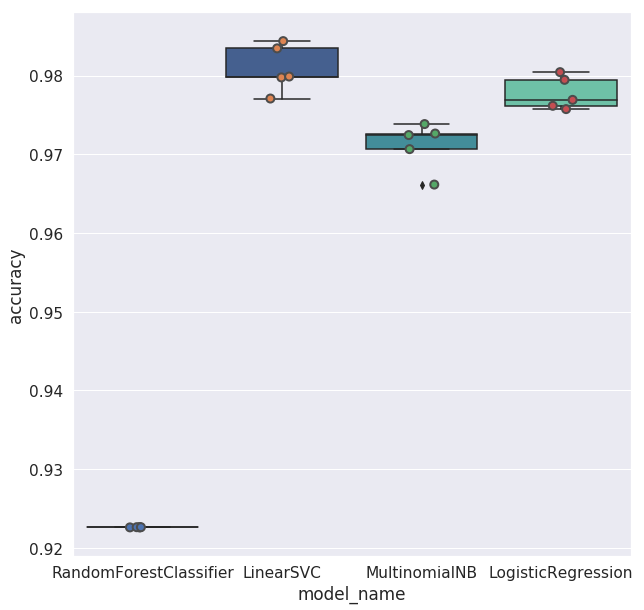

In [37]:
models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])
import seaborn as sns
plt.figure(figsize = (10,10))
sns.boxplot(x='model_name', y='accuracy', data=cv_df,palette="mako")
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [38]:
## Model Accuracies 
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC                 0.980930
LogisticRegression        0.977759
MultinomialNB             0.971160
RandomForestClassifier    0.922619
Name: accuracy, dtype: float64

### Part 4. Model Building

In [39]:
train_x, valid_x, train_y, valid_y = model_selection.train_test_split(trainDF['text75'], trainDF['flag'],random_state=42, test_size=0.25)

In [40]:
encoder = preprocessing.LabelEncoder()

train_y = encoder.fit_transform(train_y)
valid_y = encoder.fit_transform(valid_y)
test_y = encoder.fit_transform(testDF['flag'])  # for independent testing on 2000 charts

... Processing
Test accuracy is 0.9768258584051001
              precision    recall  f1-score   support

           0       0.99      0.98      0.99     41781
           1       0.77      0.91      0.84      2924

   micro avg       0.98      0.98      0.98     44705
   macro avg       0.88      0.95      0.91     44705
weighted avg       0.98      0.98      0.98     44705

threshold accuracy_score recall precision  f1_score tn  fn  fp  tp
0.1 0.9608992282742422  0.68 0.93 0.79 39735 230 1518 3222
0.2 0.9751705625768929  0.81 0.89 0.85 40517 374 736 3078
0.3 0.9780114081198971  0.86 0.86 0.86 40769 499 484 2953
0.4 0.9785035230958505  0.89 0.82 0.85 40920 628 333 2824
0.5 0.9768258584051001  0.91 0.77 0.84 40999 782 254 2670
0.6 0.9746560787383961  0.93 0.72 0.82 41072 952 181 2500
0.7 0.9715020691197852  0.95 0.67 0.78 41131 1152 122 2300
0.8 0.9669835588860306  0.96 0.59 0.74 41177 1400 76 2052
0.9 0.9593557767587518  0.98 0.49 0.65 41211 1775 42 1677


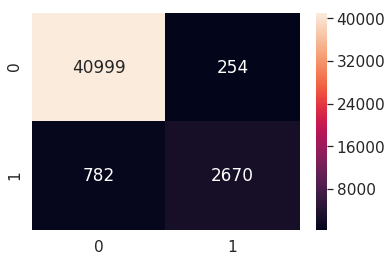

In [41]:
# when building negation model, can use ngram because it needs context
model_pipeline = Pipeline([
              #  ('tfidf',CountVectorizer(token_pattern=r'\w{3,}', stop_words='english')),
              #  ('tfidf', CountVectorizer(analyzer='word', token_pattern=r'\w{2,}', stop_words='english')),
    ('tfidf', TfidfVectorizer(analyzer='word', token_pattern=r'\w{3,}', stop_words='english',min_df=5)),
   #  ('tfidf', TfidfVectorizer(analyzer='word', token_pattern=r'\w{3,}',ngram_range=(1,2), stop_words='english',min_df=5)),
  #   ('tfidf', TfidfVectorizer(analyzer='word', token_pattern=r'\w{11,}',ngram_range=(1,11), stop_words='english',min_df=5)),
  #   ('tfidf', CountVectorizer(analyzer='word', token_pattern=r'\w{3,}',ngram_range=(1,11), stop_words='english',min_df=5)),
                ('clf', OneVsRestClassifier(LogisticRegression(solver='sag'), n_jobs=1)),])
                #('clf',OneVsRestClassifier(MultinomialNB(fit_prior=True, class_prior=None))),])
                #('clf', OneVsRestClassifier(LinearSVC(), n_jobs=1)),])
                #('clf',ensemble.RandomForestClassifier()),])
    
print('... Processing')
model_pipeline.fit(train_x,train_y)

#prediction = model_pipeline.predict(valid_x)
#print(prediction)

pred = model_pipeline.predict_proba(valid_x)
#print(pred)
y_pred = []
for row in pred:
    y_pred.append(row[1])
y_pred = np.array(y_pred)
prediction = np.where(y_pred > 0.5, 1, 0)
#print(prediction)

print('Test accuracy is {}'.format(accuracy_score(valid_y, prediction)))
conf_mat = confusion_matrix(valid_y, prediction)
df_cm = pd.DataFrame(conf_mat, range(2),
                  range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True, fmt='d')
print(classification_report(prediction, valid_y))

# below is to use probability to output class prediction, then output all metrics for each threshold
print("threshold accuracy_score recall precision  f1_score tn  fn  fp  tp")
for thres in [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]:  #no, cannot use it, this is for binary class only
    prediction = np.where(y_pred > thres, 1, 0)
        #print(prediction)
    conf_mat = confusion_matrix(valid_y, prediction)
    tn, fp, fn, tp = conf_mat.ravel()
    report = classification_report(valid_y,prediction)
    lines = report.split('\n')
    #print(lines[2])
    row_data = lines[3].split('      ')
    print(thres,accuracy_score(valid_y, prediction),row_data[2],row_data[3],row_data[4], tn, fn, fp, tp)


Test accuracy is 0.5528769239256358
              precision    recall  f1-score   support

           0       0.99      0.52      0.68     16636
           1       0.15      0.96      0.26      1491

   micro avg       0.55      0.55      0.55     18127
   macro avg       0.57      0.74      0.47     18127
weighted avg       0.92      0.55      0.65     18127

threshold accuracy_score recall precision  f1_score tn  fn  fp  tp
0.1 0.651679814641143  0.91 0.37 0.52 8326 5985 329 3487
0.2 0.601864621834832  0.93 0.26 0.40 8479 7041 176 2431
0.3 0.5799635902245269  0.95 0.21 0.34 8542 7501 113 1971
0.4 0.5656203453412038  0.95 0.18 0.30 8569 7788 86 1684
0.5 0.5528769239256358  0.96 0.15 0.26 8593 8043 62 1429
0.6 0.5407403321012854  0.97 0.13 0.22 8614 8284 41 1188
0.7 0.5286037402769349  0.97 0.10 0.18 8626 8516 29 956
0.8 0.5164119821261102  0.97 0.08 0.14 8631 8742 24 730
0.9 0.5055442158106692  0.97 0.06 0.10 8640 8948 15 524


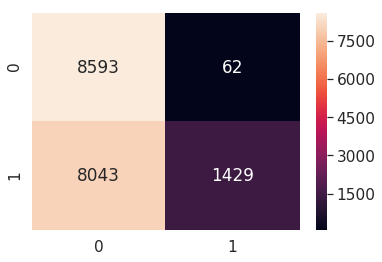

In [42]:
# testing on the 2000 charts
pred = model_pipeline.predict_proba(testDF['text75'])
#print(pred)
y_pred = []
for row in pred:
    y_pred.append(row[1])
y_pred = np.array(y_pred)
prediction = np.where(y_pred > 0.5, 1, 0)
#print(prediction)

print('Test accuracy is {}'.format(accuracy_score(test_y, prediction)))
conf_mat = confusion_matrix(test_y, prediction)
df_cm = pd.DataFrame(conf_mat, range(2),
                  range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True, fmt='d')
print(classification_report(prediction, test_y))

# below is to use probability to output class prediction, then output all metrics for each threshold
print("threshold accuracy_score recall precision  f1_score tn  fn  fp  tp")
for thres in [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]:  #no, cannot use it, this is for binary class only
    prediction = np.where(y_pred > thres, 1, 0)
        #print(prediction)
    conf_mat = confusion_matrix(test_y, prediction)
    tn, fp, fn, tp = conf_mat.ravel()
    report = classification_report(test_y,prediction)
    lines = report.split('\n')
    #print(lines[2])
    row_data = lines[3].split('      ')
    print(thres,accuracy_score(test_y, prediction),row_data[2],row_data[3],row_data[4], tn, fn, fp, tp)

In [43]:
# saving pickle files
'''
if group==1:
    category='DeletionReason'
    reason=deletionR
    joblib.dump(model_pipeline, '../picklefolder_ngrams/{}_{}_LRApril0219.pickle'.format(category,reason))
elif group==2:
    category='Phrase'
    reason=phrase
    joblib.dump(model_pipeline, '../picklefolder_ngrams/{}_{}_LRApril0219.pickle'.format(category,reason))
elif group==3:
    #category='Code'
    reason = codereason
    joblib.dump(model_pipeline, '../picklefolder_ngrams/{}_LRApril0219.pickle'.format(reason))
else:
    print('please define group so we know how to save the model...')
    

print("---pickle file dumped")

'''

'\nif group==1:\n    category=\'DeletionReason\'\n    reason=deletionR\n    joblib.dump(model_pipeline, \'../picklefolder_ngrams/{}_{}_LRApril0219.pickle\'.format(category,reason))\nelif group==2:\n    category=\'Phrase\'\n    reason=phrase\n    joblib.dump(model_pipeline, \'../picklefolder_ngrams/{}_{}_LRApril0219.pickle\'.format(category,reason))\nelif group==3:\n    #category=\'Code\'\n    reason = codereason\n    joblib.dump(model_pipeline, \'../picklefolder_ngrams/{}_LRApril0219.pickle\'.format(reason))\nelse:\n    print(\'please define group so we know how to save the model...\')\n    \n\nprint("---pickle file dumped")\n\n'

... Processing


/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Test accuracy is 0.9779219326697237
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     42010
           1       0.75      0.96      0.84      2695

   micro avg       0.98      0.98      0.98     44705
   macro avg       0.87      0.97      0.91     44705
weighted avg       0.98      0.98      0.98     44705

threshold accuracy_score recall precision  f1_score tn  fn  fp  tp
0.1 0.9511016664802595  0.62 0.93 0.75 39303 236 1950 3216
0.2 0.9734257912985125  0.79 0.90 0.84 40426 361 827 3091
0.3 0.9795324907728442  0.88 0.85 0.87 40840 502 413 2950
0.4 0.9805167207247512  0.93 0.81 0.86 41052 670 201 2782
0.5 0.9779219326697237  0.96 0.75 0.84 41138 872 115 2580
0.6 0.9745666032882228  0.97 0.69 0.81 41182 1066 71 2386
0.7 0.9687059613018678  0.98 0.61 0.75 41214 1360 39 2092
0.8 0.9606308019237222  0.99 0.50 0.66 41235 1742 18 1710
0.9 0.9491332065764456  0.99 0.34 0.51 41243 2264 10 1188


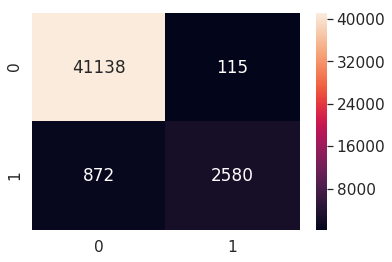

In [44]:
# RF method   # if we want to include or compare RF model
model_pipeline2 = Pipeline([
                #('tfidf',CountVectorizer(token_pattern=r'\w{3,}', stop_words='english')),
                ('tfidf', CountVectorizer(analyzer='word', token_pattern=r'\w{2,}', stop_words='english')),
    #('tfidf', TfidfVectorizer(analyzer='word', token_pattern=r'\w{3,}', stop_words='english',min_df=5)),
    #('tfidf', TfidfVectorizer(analyzer='word', token_pattern=r'\w{3,}',ngram_range=(1,11), stop_words='english',min_df=5)),
    
                #('clf', OneVsRestClassifier(LogisticRegression(solver='sag'), n_jobs=1)),])
                #('clf',OneVsRestClassifier(MultinomialNB(fit_prior=True, class_prior=None))),])
                #('clf', OneVsRestClassifier(LinearSVC(), n_jobs=1)),])
                ('clf',ensemble.RandomForestClassifier()),])
            
             
print('... Processing')
model_pipeline2.fit(train_x,train_y)
#joblib.dump(model_pipeline, './picklefolder_ngrams/PhraseReason_cholestrol.pickle') 
#print("---pickle file dumped")
#print(prediction)
pred = model_pipeline2.predict_proba(valid_x)
#print(pred)
y_pred = []
for row in pred:
    y_pred.append(row[1])
y_pred = np.array(y_pred)
prediction = np.where(y_pred > 0.5, 1, 0)
#print(prediction)

print('Test accuracy is {}'.format(accuracy_score(valid_y, prediction)))
conf_mat = confusion_matrix(valid_y, prediction)
df_cm = pd.DataFrame(conf_mat, range(2),
                  range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True, fmt='d')
print(classification_report(prediction, valid_y))

# below is to use probability to output class prediction, then output all metrics for each threshold
print("threshold accuracy_score recall precision  f1_score tn  fn  fp  tp")
for thres in [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]:  #no, cannot use it, this is for binary class only
    prediction = np.where(y_pred > thres, 1, 0)
        #print(prediction)
    conf_mat = confusion_matrix(valid_y, prediction)
    tn, fp, fn, tp = conf_mat.ravel()
    report = classification_report(valid_y,prediction)
    lines = report.split('\n')
    #print(lines[2])
    row_data = lines[3].split('      ')
    print(thres,accuracy_score(valid_y, prediction),row_data[2],row_data[3],row_data[4], tn, fn, fp, tp)
    

# saving pickle files
#joblib.dump(model_pipeline, '../picklefolder_ngrams/PhraseReason_{}_RFApril0219.pickle'.format(phrase)) 
#print("---pickle file dumped")
  


Test accuracy is 0.5545870800463397
              precision    recall  f1-score   support

           0       1.00      0.52      0.68     16649
           1       0.15      0.97      0.26      1478

   micro avg       0.55      0.55      0.55     18127
   macro avg       0.57      0.75      0.47     18127
weighted avg       0.93      0.55      0.65     18127

threshold accuracy_score recall precision  f1_score tn  fn  fp  tp
0.1 0.6329232636398742  0.87 0.35 0.50 8145 6144 510 3328
0.2 0.606167595299829  0.92 0.27 0.42 8423 6907 232 2565
0.3 0.5834942351188834  0.95 0.22 0.35 8537 7432 118 2040
0.4 0.5683234953384454  0.96 0.18 0.30 8589 7759 66 1713
0.5 0.5545870800463397  0.97 0.15 0.26 8615 8034 40 1438
0.6 0.5420091576101947  0.98 0.13 0.22 8625 8272 30 1200
0.7 0.530148397418216  0.98 0.10 0.19 8639 8501 16 971
0.8 0.518784134164506  0.98 0.08 0.15 8641 8709 14 763
0.9 0.5051580515253489  0.99 0.05 0.10 8648 8963 7 509


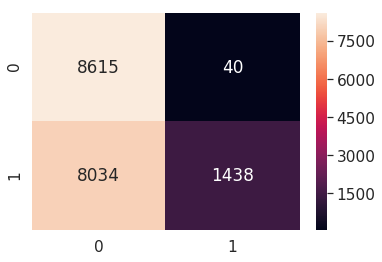

In [45]:
# testing on the 2000 charts
pred = model_pipeline2.predict_proba(testDF['text75'])
#print(pred)
y_pred = []
for row in pred:
    y_pred.append(row[1])
y_pred = np.array(y_pred)
prediction = np.where(y_pred > 0.5, 1, 0)
#print(prediction)

print('Test accuracy is {}'.format(accuracy_score(test_y, prediction)))
conf_mat = confusion_matrix(test_y, prediction)
df_cm = pd.DataFrame(conf_mat, range(2),
                  range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True, fmt='d')
print(classification_report(prediction, test_y))

# below is to use probability to output class prediction, then output all metrics for each threshold
print("threshold accuracy_score recall precision  f1_score tn  fn  fp  tp")
for thres in [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]:  #no, cannot use it, this is for binary class only
    prediction = np.where(y_pred > thres, 1, 0)
        #print(prediction)
    conf_mat = confusion_matrix(test_y, prediction)
    tn, fp, fn, tp = conf_mat.ravel()
    report = classification_report(test_y,prediction)
    lines = report.split('\n')
    #print(lines[2])
    row_data = lines[3].split('      ')
    print(thres,accuracy_score(test_y, prediction),row_data[2],row_data[3],row_data[4], tn, fn, fp, tp)

####('clf',OneVsRestClassifier(MultinomialNB(fit_prior=True, class_prior=None))),])
####('clf', OneVsRestClassifier(LinearSVC(), n_jobs=1)),])
####('clf', OneVsRestClassifier(LogisticRegression(solver='sag'), n_jobs=1)),])
####('clf',ensemble.RandomForestClassifier()),])

### Saving the notebook as html and change the name to the corresponding model

In [46]:
'''
if group==1:
    category='DeletionReason'
    reason=deletionR
    name= category+'_'+reason
elif group==2:
    category='Phrase'
    reason=phrase
    name= category+'_'+reason
elif group==3:
    #category='Code'
    reason = codereason
    name=reason
else:
    print('please define group so we know how to save the model...')
    
    # please rerun this part after the notebook finished running manually to save the display of the results from above
!jupyter nbconvert --to html phrase_code_deletion_based_general_April02.ipynb
os.rename('phrase_code_deletion_based_general_April02.html', '{}_April0319.html'.format(name))
'''

"\nif group==1:\n    category='DeletionReason'\n    reason=deletionR\n    name= category+'_'+reason\nelif group==2:\n    category='Phrase'\n    reason=phrase\n    name= category+'_'+reason\nelif group==3:\n    #category='Code'\n    reason = codereason\n    name=reason\nelse:\n    print('please define group so we know how to save the model...')\n    \n    # please rerun this part after the notebook finished running manually to save the display of the results from above\n!jupyter nbconvert --to html phrase_code_deletion_based_general_April02.ipynb\nos.rename('phrase_code_deletion_based_general_April02.html', '{}_April0319.html'.format(name))\n"